### DATA PREPARATION

In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
import tensorflow as tf

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100110323_standard.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP
READ_DATE,
2019-01-01 00:00:00,2.334143
2019-01-01 00:15:00,2.344050
2019-01-01 00:30:00,2.500311
2019-01-01 00:45:00,2.432096
2019-01-01 01:00:00,2.388465
...,...
2024-05-31 21:45:00,68.226236
2024-05-31 22:00:00,69.132420
2024-05-31 23:15:00,68.774401


In [35]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

In [36]:
scaler = StandardScaler()

In [37]:
# scaling data train
train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
train_scaled



,KWH_EXP
READ_DATE,
2019-01-01 00:00:00,-0.913157
2019-01-01 00:15:00,-0.911948
2019-01-01 00:30:00,-0.892871
2019-01-01 00:45:00,-0.901199
2019-01-01 01:00:00,-0.906525
...,...
2022-12-31 22:45:00,-0.848218
2022-12-31 23:00:00,-0.840862
2022-12-31 23:15:00,-0.842761


In [38]:
# scaling data test
test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
test_scaled

,KWH_EXP
READ_DATE,
2023-01-01 00:00:00,-0.836886
2023-01-01 00:15:00,-0.830567
2023-01-01 00:30:00,-0.833519
2023-01-01 00:45:00,-0.856909
2023-01-01 01:00:00,-0.828039
...,...
2024-05-31 21:45:00,7.131126
2024-05-31 22:00:00,7.241755
2024-05-31 23:15:00,7.198047


In [39]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [40]:
# jika datanya diambil setiap 15 menit, maka time_steps = 96 berarti 24 jam

time_steps = 96
# reshape ke bentuk 3D array
X_train, y_train = create_dataset(train_scaled, train_scaled['KWH_EXP'], time_steps)
X_test, y_test = create_dataset(test_scaled, test_scaled['KWH_EXP'], time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(122823, 96, 1) (122823,)
(43087, 96, 1) (43087,)



<h4>SPLITTING DATA RATIO :

* Train data : tahun 2019-2022 akhir
* Test data : tahun 2023-ujung data
* Validation data : diambil 10% dari training data. Nantinya parameter `validation_split` di `model.fit` akan melakukan splitting data train

### TRAINING WITH BIDIRECTIONAL-LSTM

In [41]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 96, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,601 (1.14 MB)

 Trainable params: 297,601 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
#  callback
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
# learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - loss: 0.1258 - val_loss: 0.0261 - learning_rate: 0.0010
Epoch 2/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0479 - val_loss: 0.0146 - learning_rate: 0.0010
Epoch 3/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0320 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 4/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0237 - val_loss: 0.0125 - learning_rate: 0.0010
Epoch 5/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0271 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 6/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0198 - val_loss: 0.0074 - learning_rate: 9.0484e-04
Epoch 7/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 0.0187 - val_loss: 0.0070 - learning_rate: 8.1873e-04
Epoch 8/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - loss: 0.0183 - val_loss: 0.0068 - learning_rate: 7.4082e-04
Epoch 9/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 0.0181 - val_loss: 0.

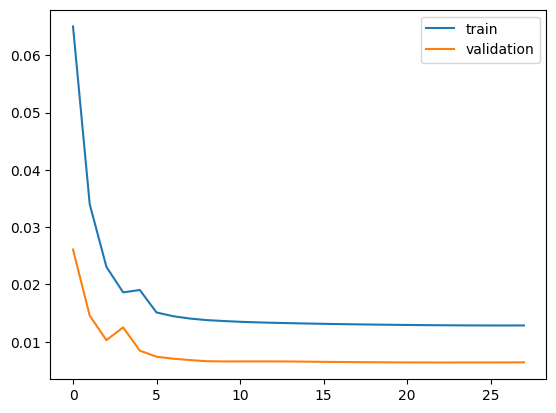

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [45]:
# predict

y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)


1347/1347 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


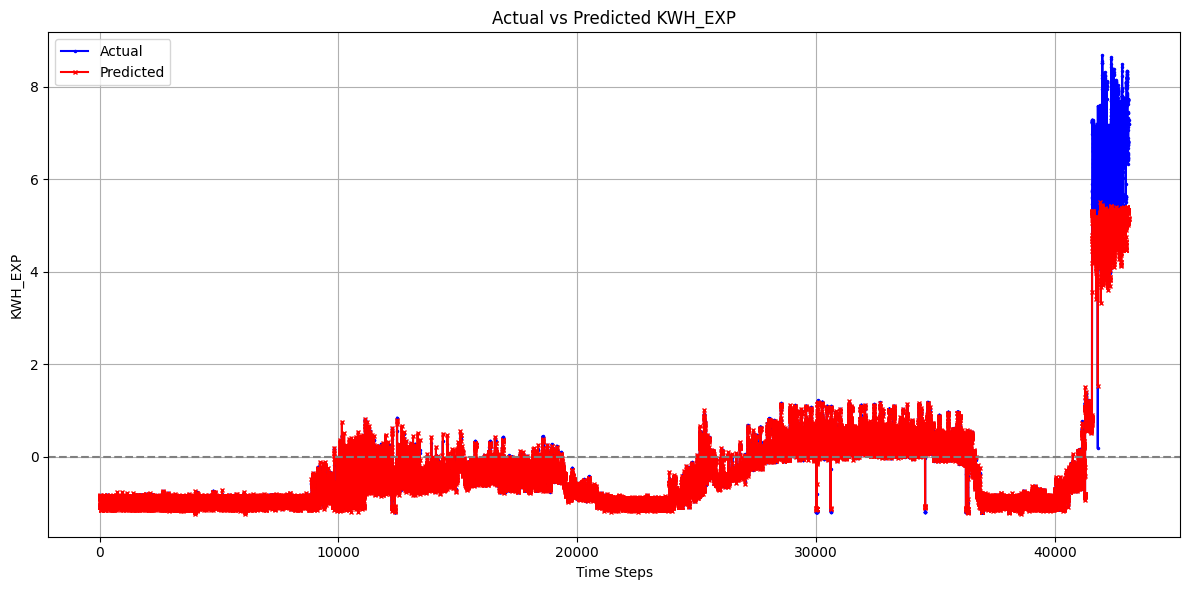

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Garis referensi
plt.title('Actual vs Predicted KWH_EXP')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [47]:
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.1113402292624524
MAE: 0.08531080508110514
R2: 0.9449800575563614
MAPE: 0.5748783057534179


### TRAINING WITH LSTM + ATTENTION LAYER

In [48]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = LSTM(units=128, return_sequences=True)(inputs)
x = AttentionLayer()(x)
x = LSTM(units=64, return_sequences=False)(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 96, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 96, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_2 (AttentionLayer)   │ (None, 96, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.3025 - val_loss: 0.0743 - learning_rate: 0.0010
Epoch 2/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.1622 - val_loss: 0.1215 - learning_rate: 0.0010
Epoch 3/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.1545 - val_loss: 0.0776 - learning_rate: 0.0010
Epoch 4/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.1197 - val_loss: 0.0967 - learning_rate: 0.0010
Epoch 5/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.1248 - val_loss: 0.0747 - learning_rate: 0.0010
Epoch 6/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0992 - val_loss: 0.0691 - learning_rate: 9.0484e-04
Epoch 7/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0915 - val_loss: 0.0491 - learning_rate: 8.1873e-04
Epoch 8/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0788 - val_loss: 0.0420 - learning_rate: 7.4082e-04
Epoch 9/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0751 - val_loss: 0.0420 - le

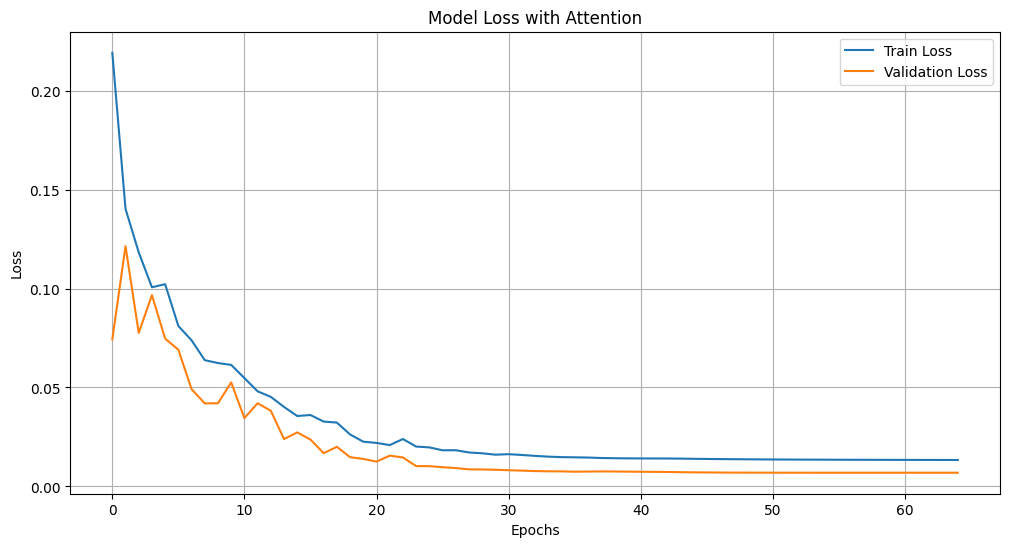

1347/1347 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [49]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

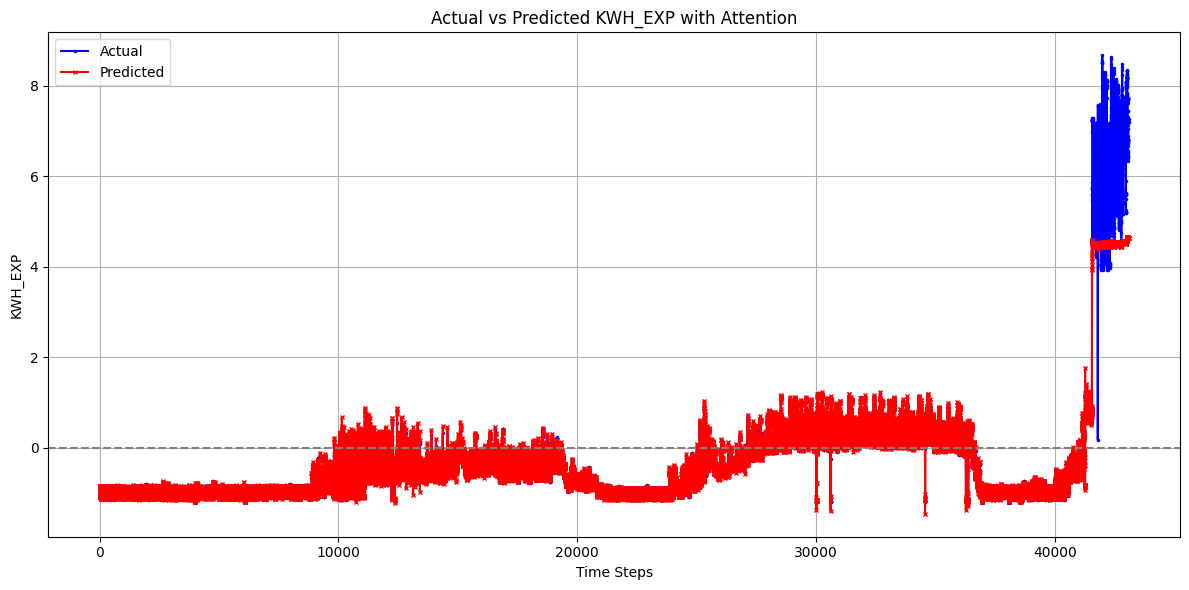

In [50]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [51]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.18609081220102322
MAE: 0.10233420083998243
R²: 0.9080412727330077
MAPE: 0.6460493275636937


### TRAINING WITH BIDIRECTIONAL LSTM + ATTENTION LAYER

In [52]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = Bidirectional(LSTM(units=128, return_sequences=True))(inputs)
x = AttentionLayer()(x)
x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 96, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 96, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_3 (AttentionLayer)   │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,601 (1.14 MB)

 Trainable params: 297,601 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - loss: 0.2737 - val_loss: 0.0729 - learning_rate: 0.0010
Epoch 2/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.1398 - val_loss: 0.0841 - learning_rate: 0.0010
Epoch 3/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.1063 - val_loss: 0.0513 - learning_rate: 0.0010
Epoch 4/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0643 - val_loss: 0.0436 - learning_rate: 0.0010
Epoch 5/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0566 - val_loss: 0.0338 - learning_rate: 0.0010
Epoch 6/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0467 - val_loss: 0.0220 - learning_rate: 9.0484e-04
Epoch 7/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0357 - val_loss: 0.0141 - learning_rate: 8.1873e-04
Epoch 8/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0314 - val_loss: 0.0888 - learning_rate: 7.4082e-04
Epoch 9/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0737 - val_loss: 0.

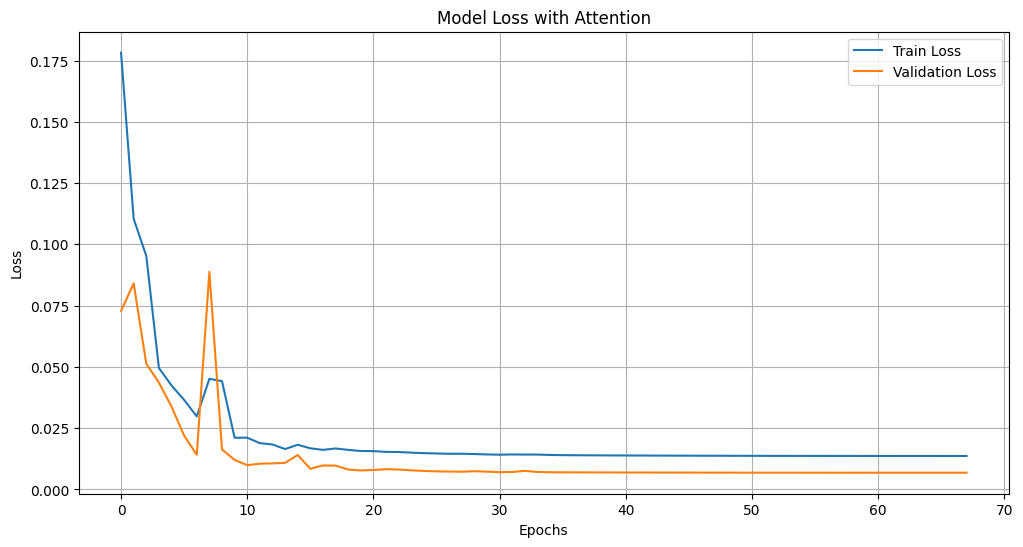

1347/1347 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


In [53]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

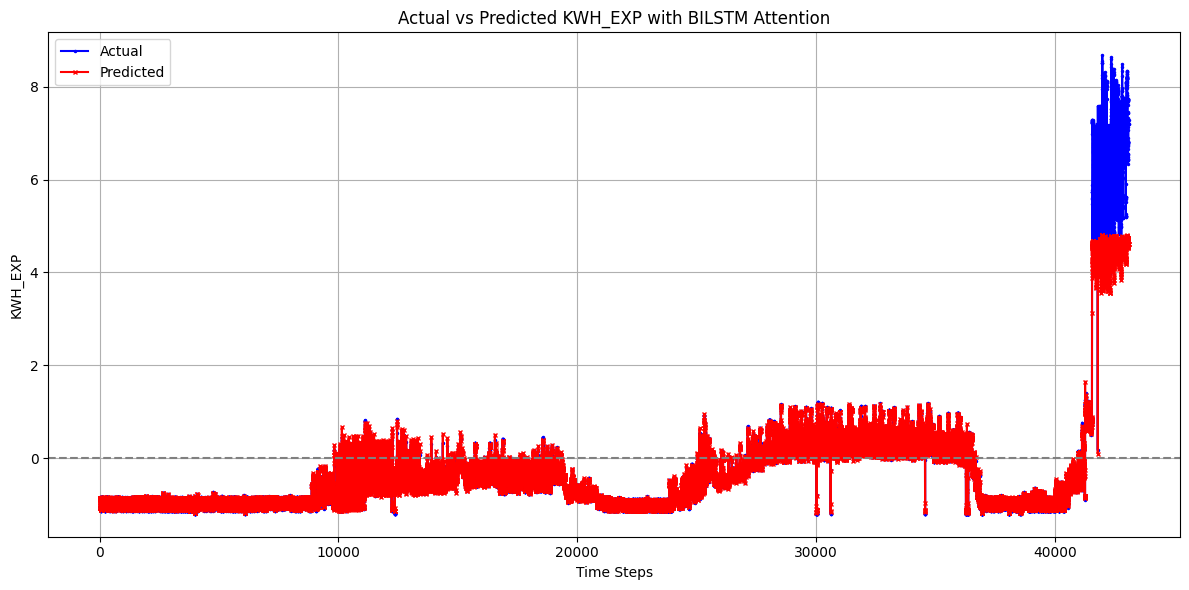

In [54]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with BILSTM Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [55]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.17737596643452727
MAE: 0.10254875554267726
R²: 0.9123478052024849
MAPE: 0.644942104722338


### TRAINING WITH LSTM

In [56]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 96, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 96, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_3 (AttentionLayer)   │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,601 (1.14 MB)

 Trainable params: 297,601 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - loss: 0.0305 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 2/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0355 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 3/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0309 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 4/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0450 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 5/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0359 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 6/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0289 - val_loss: 0.0156 - learning_rate: 9.0484e-04
Epoch 7/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0267 - val_loss: 0.0109 - learning_rate: 8.1873e-04
Epoch 8/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0216 - val_loss: 0.0136 - learning_rate: 7.4082e-04
Epoch 9/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0222 - val_loss: 0.

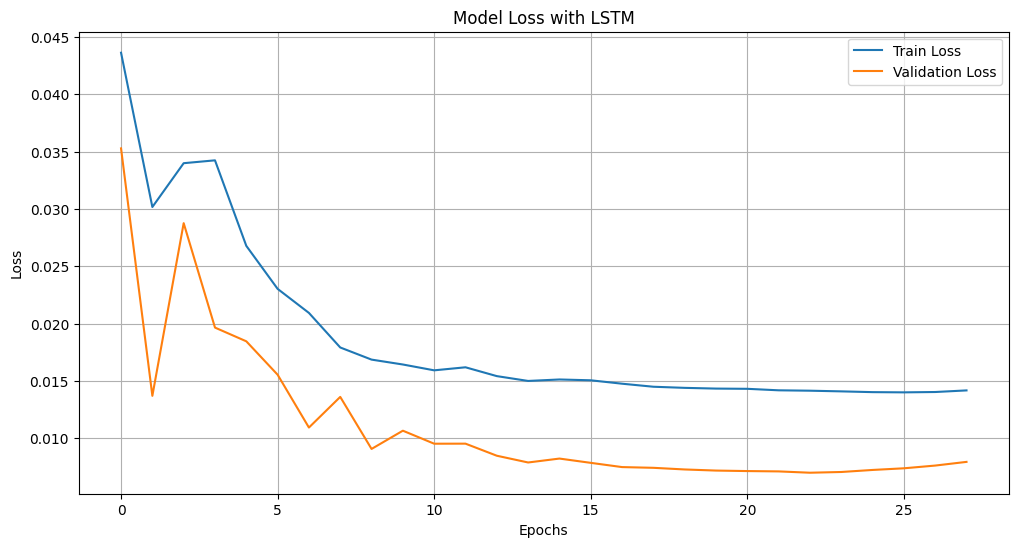

1347/1347 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


In [57]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

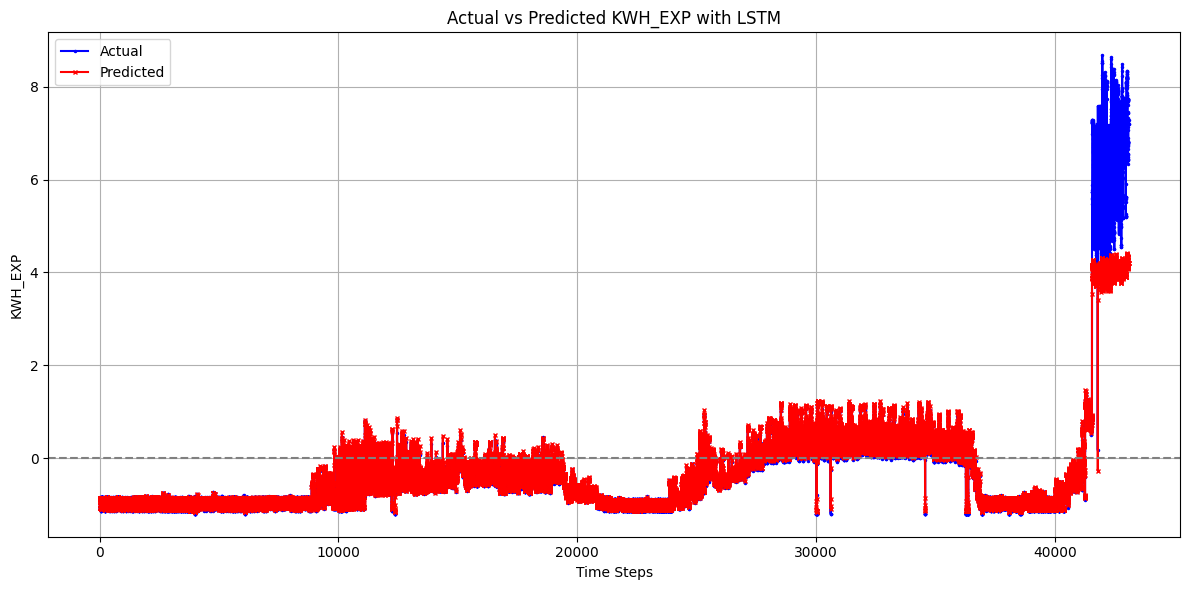

In [58]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with LSTM')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [59]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.2500978779071659
MAE: 0.12594523235847038
R²: 0.8764115096683309
MAPE: 0.6459769319053636
